In [1]:


import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from datetime import datetime
import os
from thermal_lib import *
from tqdm import tqdm
import pingouin as pg
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib

def plot_avg(var, isDay, draw_sub=True, draw_sem = True, draw_zero = False, ax=None, color='b'):

    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    if draw_zero:
        ax.axhline(0,color='k',linestyle='--')

    if draw_sub:
        for c in var.columns:
            ax.plot(var.index, var[c],color,alpha=.1)

    avg = var.mean(axis=1) 

    if draw_sem:
        sem = var.sem(axis=1) 
        ax.fill_between(var.index, avg+sem, avg-sem, alpha=.3, color=color,edgecolor='none')

    ax.plot(var.index, avg,color,alpha=1)
    xlims = [var.index[0], var.index[-1]]
    ax.set_xlim(xlims)
    ylims = ax.get_ylim()
    ax.fill_between(var.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
    ax.set_ylim(ylims)
    #ax.set_xlabel('Time [Hours]')
    
def plot_raw(data=None, y=None, x=None, isDay=None, ax=None, hzero=True):
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(8,3))

    if x is None:
        x = data.index
    
    if hzero:
        ax.axhline(0,color='k',linestyle='--')
    
    ax.plot(x, data[y] )
    ax.set_ylim([data[y].min()*1.1, data[y].max()*1.1 ])
    ylims = ax.get_ylim()
    ax.fill_between(x, where=data['isDay']==0, 
                    y1=ylims[0], 
                    y2=ylims[1], 
                    color='gray', alpha=.2, edgecolor='None' )

    ax.set_xlim([x[0], x[-1]])
    return ax

def actogram(in_each_day, ax=None, baseline=True,linecolor='tab:blue',isDay=None):
    each_day = in_each_day.copy()

    each_day = each_day/each_day.abs().max().max()
    spacing = 1.5
    
    mot_day_tick = list()
    mot_day_tick_lbl = list()
    all_days = len(each_day.columns)
    for i,c in enumerate(each_day.columns):    
        each_day[c] = each_day[c] + spacing*(all_days-i)
        mot_day_tick.append(spacing*(all_days-i))
        mot_day_tick_lbl.append(i)
    
    if ax is None:
        fig,ax = plt.subplots(figsize=(4,5))
        ax.set_ylabel('Day')
        ax.set_xlabel('Hour')
    if baseline:
        for b in mot_day_tick:
            ax.axhline(b,color='k',linestyle='--')
    ax.plot(each_day.index,each_day,linecolor)
    if isDay is not None:
        ylims = ax.get_ylim()
        ax.fill_between(isDay.index,y1=ylims[0],y2=ylims[1],where=isDay<1,color='gray',edgecolor='None',alpha=.4)
        
    ax.set_yticks(mot_day_tick)
    #ax.set_yticklabels(mot_day_tick_lbl)
    
    ax.set_xlim(each_day.index[0],each_day.index[-1])
    
    if isDay is None:
        ylims = ax.get_ylim()
    ax.set_ylim(ylims)
    


def swarmbox(data,x,y,ax=None,palette=None,order=None):
    PROPS = {'boxprops':{'facecolor':'none'}}
    sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
    sns.boxplot(data=data,x=x,y=y,palette=palette,ax=ax,order=order,width=0.3,fliersize=0, **PROPS)

    box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
    if len(box_patches) == 0:  
        box_patches = ax.artists
    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    if type(palette)==dict:
        palette=[i[1] for i in list(palette.items()) ]
    for i, patch in enumerate(box_patches):
        if i==0:
            col=palette[0]
        else:
            col=palette[1]
        patch.set_edgecolor(col)
        for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
            line.set_color(col)
    
%matplotlib notebook

/home/oldboy/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
/home/oldboy/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:

pth = r'D:\thermography\cdkl5_thermal_behaviour_group1\unico'
pth = None
sub = Subjects(pth)
print(sub)

Number of Subjects: 16

0 -> ID: WT_74 RECs: 3
1 -> ID: WT_91 RECs: 3
2 -> ID: WT_97 RECs: 3
3 -> ID: KO_70 RECs: 3
4 -> ID: KO_72 RECs: 3
5 -> ID: KO_99 RECs: 3
6 -> ID: WT_86 RECs: 3
7 -> ID: WT_83 RECs: 3
8 -> ID: KO_87 RECs: 3
9 -> ID: WT_79 RECs: 3
10 -> ID: KO_69 RECs: 3
11 -> ID: KO_1021 RECs: 3
12 -> ID: KO_77 RECs: 3
13 -> ID: WT_71 RECs: 3
14 -> ID: WT_81 RECs: 3
15 -> ID: KO_75 RECs: 3



# Grand Average

## Average 24h activity

In [4]:

# motion & temperature
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_day_avg() , total=len(sub) ):
    rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_corrected']
    isDay.append(rec['isDay'])
    
isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)
#time_range = pd.timedelta_range(start='0 days 10:00:00', end='1 days 09:59:00', freq='1min')





100%|██████████| 16/16 [00:00<00:00, 117.78it/s]


<IPython.core.display.Javascript object>


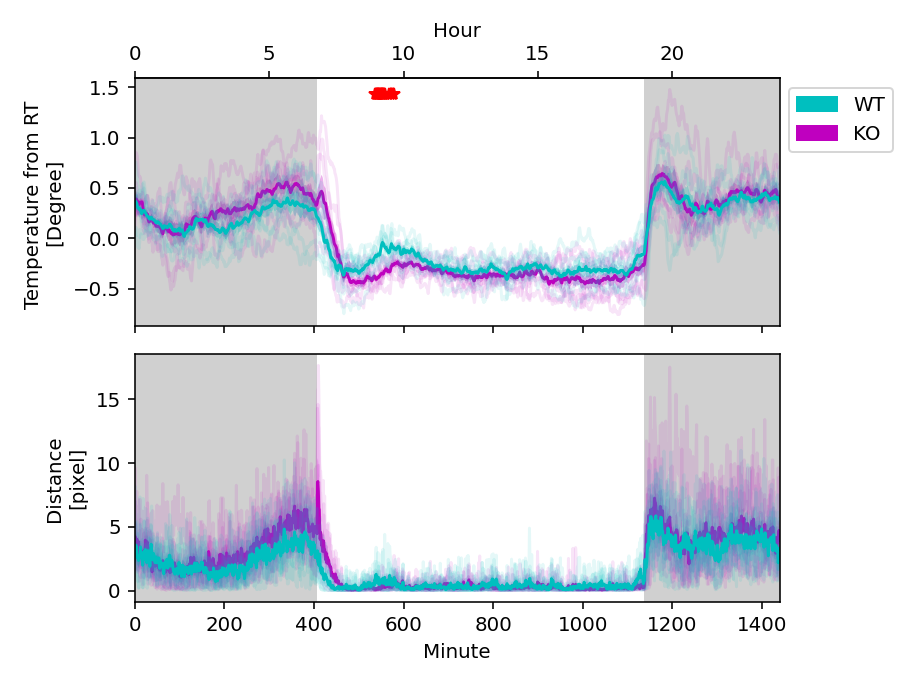

In [5]:
fig,ax = plt.subplots(2,1,sharex=True) 

wt_patch = mpatches.Patch(color='c', label='WT')
ko_patch = mpatches.Patch(color='m', label='KO')
ax[0].legend(handles=[wt_patch, ko_patch],bbox_to_anchor=(1, 1),)

plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

temperature_ttests = list()
for i,row in temperature.iterrows():
    temp = pg.ttest(row['WT'].values,row['KO'].values)
    temp['minute'] = i
    temperature_ttests.append( temp )
temperature_ttests = pd.concat(temperature_ttests).sort_values(by='p-val')    
reject, pvals_corr = pg.multicomp(temperature_ttests['p-val'], method='fdr_bh')
temperature_ttests['p-corr'] = pvals_corr

pval_signi = temperature_ttests[temperature_ttests['p-corr']<0.05] #temperature_ttests[temperature_ttests['p-corr']<0.05] #
signi_pos = np.max(ax[0].get_ylim())*.9
ax[0].plot( pval_signi.minute, np.repeat(signi_pos,len(pval_signi)),'*r' )

motion_ttests = list()
for i,row in motion.iterrows():
    temp = pg.ttest(row['WT'].values,row['KO'].values)
    temp['minute'] = i
    motion_ttests.append( temp )
motion_ttests = pd.concat(motion_ttests).sort_values(by='p-val')    
reject, pvals_corr = pg.multicomp(motion_ttests['p-val'], method='fdr_bh')
motion_ttests['p-corr'] = pvals_corr

pval_signi = motion_ttests[motion_ttests['p-corr']<0.05] #motion_ttests[motion_ttests['p-val']<0.05] #
signi_pos = np.max(ax[1].get_ylim())*.9
ax[1].plot( pval_signi.minute, np.repeat(signi_pos,len(pval_signi)),'*r' )



plt.tight_layout()

## Average all tracks

In [3]:
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_data() , total=len(sub) ):
    #rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])

isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)

100%|██████████| 16/16 [00:00<00:00, 20.54it/s]


<IPython.core.display.Javascript object>


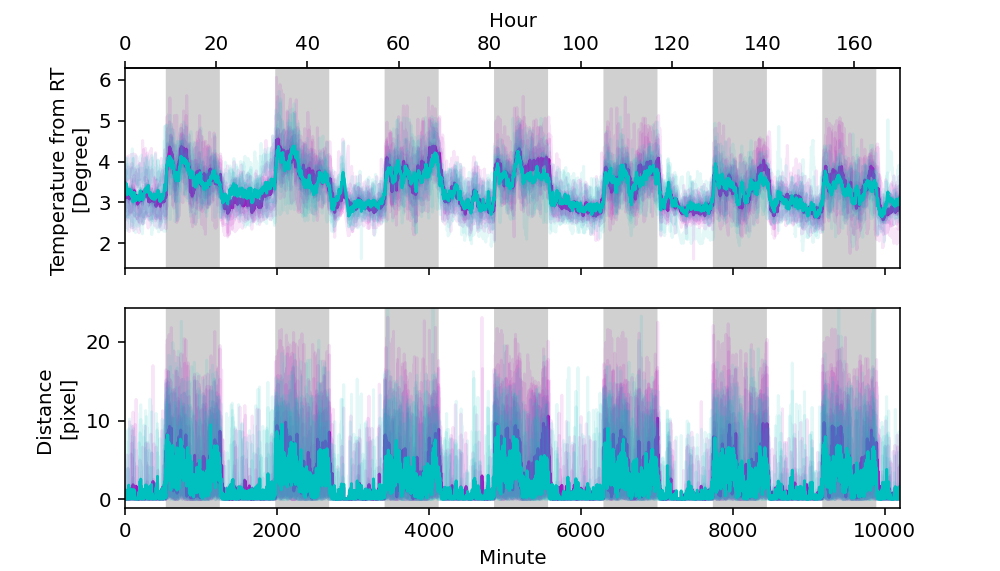

Text(0.5, 0, 'Minute')

In [4]:
fig,ax = plt.subplots(2,1,sharex=True, figsize=(7,4)) 
plot_avg( temperature.xs('KO',level=0,axis=1), isDay,color='m',ax=ax[0])
plot_avg( temperature.xs('WT',level=0,axis=1), isDay,color='c',ax=ax[0])
ax[0].set_ylabel('Temperature from RT \n[Degree]')
ax2 = ax[0].secondary_xaxis("top", functions=(lambda x: x/60, lambda x: x*60))
ax2.set_xlabel('Hour')

plot_avg( motion.xs('KO',level=0,axis=1), isDay,color='m', ax=ax[1])
plot_avg( motion.xs('WT',level=0,axis=1), isDay,color='c', ax=ax[1])
ax[1].set_ylabel('Distance \n[pixel]')
ax[1].set_xlabel('Minute')

## Cross Correlation

In [7]:
cc_data = list()
cross_corr_curves = list()
for i,(geno,chi) in enumerate(temperature.columns):
    cc = CrossCorrelation(temperature[geno][chi], motion[geno][chi],60)
    summary = cc.summary
    summary.insert(0, 'sub', chi)
    summary.insert(1, 'geno', geno)
    cc_data.append(summary)
    
    cc_temp = pd.DataFrame(cc.cross_correlation).T
    cc_temp.insert(0, 'sub', chi)
    cc_temp.insert(1,'geno', geno)
    cross_corr_curves.append(cc_temp)

#fig,ax = plt.subplots()
#cc.plot() #ax=ax)
#plt.tight_layout()
cc_data = pd.concat(cc_data)
cross_corr_curves = pd.concat(cross_corr_curves)



<IPython.core.display.Javascript object>


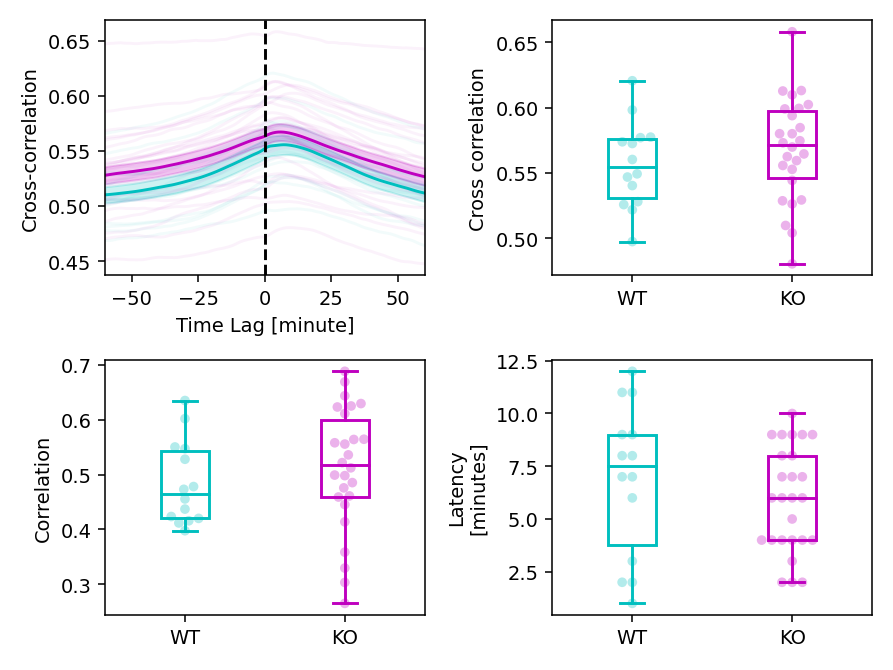

C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\3558646645.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],alpha=.3,order=['WT','KO'])
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\3558646645.py:50: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],alpha=.3,order=['WT','KO'])
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\3558646645.py:75: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],alpha=.3,order=['WT','KO'])


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,0.990031,31.277044,two-sided,0.329757,"[-0.01, 0.04]",0.310248,0.469,0.149457,amplitude
T-test,0.915842,35.777990,two-sided,0.365882,"[-0.03, 0.09]",0.270823,0.444,0.125237,corr_coeff
T-test,-0.863846,19.774389,two-sided,0.398030,"[-3.19, 1.32]",0.320104,0.429,0.156058,latency


In [8]:
import matplotlib
fig,ax = plt.subplots(2,2)
wt_cross_corr_curves = cross_corr_curves[cross_corr_curves['geno']=='WT']
ko_cross_corr_curves = cross_corr_curves[cross_corr_curves['geno']=='KO']
ax[0,0].plot(cc.latencies, wt_cross_corr_curves.iloc[:,2:].T,'c',alpha=.05 )
ax[0,0].plot(cc.latencies, ko_cross_corr_curves.iloc[:,2:].T,'m',alpha=.05 )

wt_mean = wt_cross_corr_curves.iloc[:,2:].T.mean(axis=1)
wt_sem = wt_cross_corr_curves.iloc[:,2:].T.sem(axis=1)
ax[0,0].plot(cc.latencies, wt_mean,'c',alpha=1 )
ax[0,0].fill_between(cc.latencies, y1=wt_mean-wt_sem, y2=wt_mean+wt_sem,color ='c', alpha=.2)

ko_mean = ko_cross_corr_curves.iloc[:,2:].T.mean(axis=1)
ko_sem = ko_cross_corr_curves.iloc[:,2:].T.sem(axis=1)
ax[0,0].plot(cc.latencies, ko_cross_corr_curves.iloc[:,2:].T.mean(axis=1),'m',alpha=1 )
ax[0,0].fill_between(cc.latencies, y1=ko_mean-ko_sem, y2=ko_mean+ko_sem,color ='m', alpha=.2 )

ax[0,0].axvline(0,color='k',linestyle='--')

ax[0,0].set_ylabel('Cross-correlation')
ax[0,0].set_xlabel('Time Lag [minute]')
ax[0,0].set_xlim([-60,60])

PROPS = {'boxprops':{'facecolor':'none'}}
sns.swarmplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='amplitude',palette={'WT':'c','KO':'m'},ax=ax[0,1],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[0,1].set_ylabel('Cross correlation')
ax[0,1].set_xlabel('')

box_patches = [patch for patch in ax[0,1].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,0].artists
    box_patches = ax[0,1].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[0,1].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[0,1].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers

sns.swarmplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='corr_coeff',palette={'WT':'c','KO':'m'},ax=ax[1,0],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[1,0].set_ylabel('Correlation')
ax[1,0].set_xlabel('')

box_patches = [patch for patch in ax[1,0].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,0].artists
    box_patches = ax[1,0].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[1,0].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[1,0].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers
        
sns.swarmplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],alpha=.3,order=['WT','KO'])
sns.boxplot(data=cc_data,x='geno',y='latency_minute',palette={'WT':'c','KO':'m'},ax=ax[1,1],order=['WT','KO'],width=0.3,fliersize=0, **PROPS)
ax[1,1].set_ylabel('Latency\n[minutes]')
ax[1,1].set_xlabel('')

box_patches = [patch for patch in ax[1,1].patches if type(patch) == matplotlib.patches.PathPatch]
if len(box_patches) == 0:  # in matplotlib older than 3.5, the boxes are stored in ax[1,1].artists
    box_patches = ax[1,1].artists
num_patches = len(box_patches)
lines_per_boxplot = len(ax[1,1].lines) // num_patches
for i, patch in enumerate(box_patches):
    if i==0:
        col='c'
    else:
        col='m'
    patch.set_edgecolor(col)
    #patch.set_facecolor('None')

    # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # Loop over them here, and use the same color as above
    for line in ax[1,1].lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        #line.set_mfc(col)  # facecolor of fliers
        #line.set_mec(col)  # edgecolor of fliers

plt.tight_layout()

ko_cc_amp = cc_data[cc_data['geno']=='KO']['amplitude']
wt_cc_amp = cc_data[cc_data['geno']=='WT']['amplitude']
stats_cc_amp = pg.ttest(ko_cc_amp, wt_cc_amp)
stats_cc_amp['what'] = 'amplitude'

ko_cc_corr_coeff = cc_data[cc_data['geno']=='KO']['corr_coeff']
wt_cc_corr_coeff = cc_data[cc_data['geno']=='WT']['corr_coeff']
stats_cc_corr_coeff = pg.ttest(ko_cc_corr_coeff, wt_cc_corr_coeff)
stats_cc_corr_coeff['what'] = 'corr_coeff'

ko_cc_lat = cc_data[cc_data['geno']=='KO']['latency_minute']
wt_cc_lat = cc_data[cc_data['geno']=='WT']['latency_minute']
stats_cc_lat = pg.ttest(ko_cc_lat, wt_cc_lat)
stats_cc_lat['what'] = 'latency'

pd.concat([stats_cc_amp, stats_cc_corr_coeff,stats_cc_lat] )

## Periodogram

In [9]:
isDay = list()
temperature = dict()
motion = dict()
for info,rec in tqdm( sub.iter_data() , total=len(sub) ):
    #rec = rec.sort_values(by='minute').reset_index(drop=True)
    motion[(info['geno'], info['id'])] = rec['distance']
    temperature[(info['geno'], info['id'])] = rec['temp_rt_diff']
    isDay.append(rec['isDay'])

isDay = pd.concat(isDay,axis=1).mean(axis=1)
motion = pd.DataFrame.from_dict(motion)
temperature = pd.DataFrame.from_dict(temperature,)

100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


In [10]:
temp_periodogram_data = list()
mot_periodogram_data = list()

temp_periodogram_amps = {'sub':list(), 'geno':list(), '24':list(), '12':list(), '8':list()}
mot_periodogram_amps = {'sub':list(), 'geno':list(), '24':list(), '12':list(), '8':list()}

for i,(geno,chi) in enumerate(temperature.columns):
    temp = Periodogram(temperature[geno][chi],fs=60)
    mot = Periodogram(motion[geno][chi],fs=60)
    
    temp_ps = pd.DataFrame(temp.power_spectrum,index=temp.period).T 
    temp_ps.insert(0, 'sub', chi)
    temp_ps.insert(1, 'geno', geno)
    temp_periodogram_data.append(temp_ps)
    
    mot_ps = pd.DataFrame(mot.power_spectrum,index=mot.period).T 
    mot_ps.insert(0, 'sub', chi)
    mot_ps.insert(1, 'geno', geno)
    mot_periodogram_data.append(mot_ps)
    
    temp_periodogram_amps['sub'].append(chi)
    temp_periodogram_amps['geno'].append(geno)
    temp_periodogram_amps['24'].append(float( temp.interp_func(24) ))
    temp_periodogram_amps['12'].append(float( temp.interp_func(12) ))
    temp_periodogram_amps['8'].append(float( temp.interp_func(8) ))
    
    mot_periodogram_amps['sub'].append(chi)
    mot_periodogram_amps['geno'].append(geno)
    mot_periodogram_amps['24'].append(float( mot.interp_func(24) ))
    mot_periodogram_amps['12'].append(float( mot.interp_func(12) ))
    mot_periodogram_amps['8'].append(float( mot.interp_func(8) ))
    
temp_periodogram_data = pd.concat(temp_periodogram_data)
mot_periodogram_data = pd.concat(mot_periodogram_data)

temp_periodogram_amps = pd.DataFrame(temp_periodogram_amps).infer_objects()
mot_periodogram_amps = pd.DataFrame(mot_periodogram_amps).infer_objects()


<IPython.core.display.Javascript object>


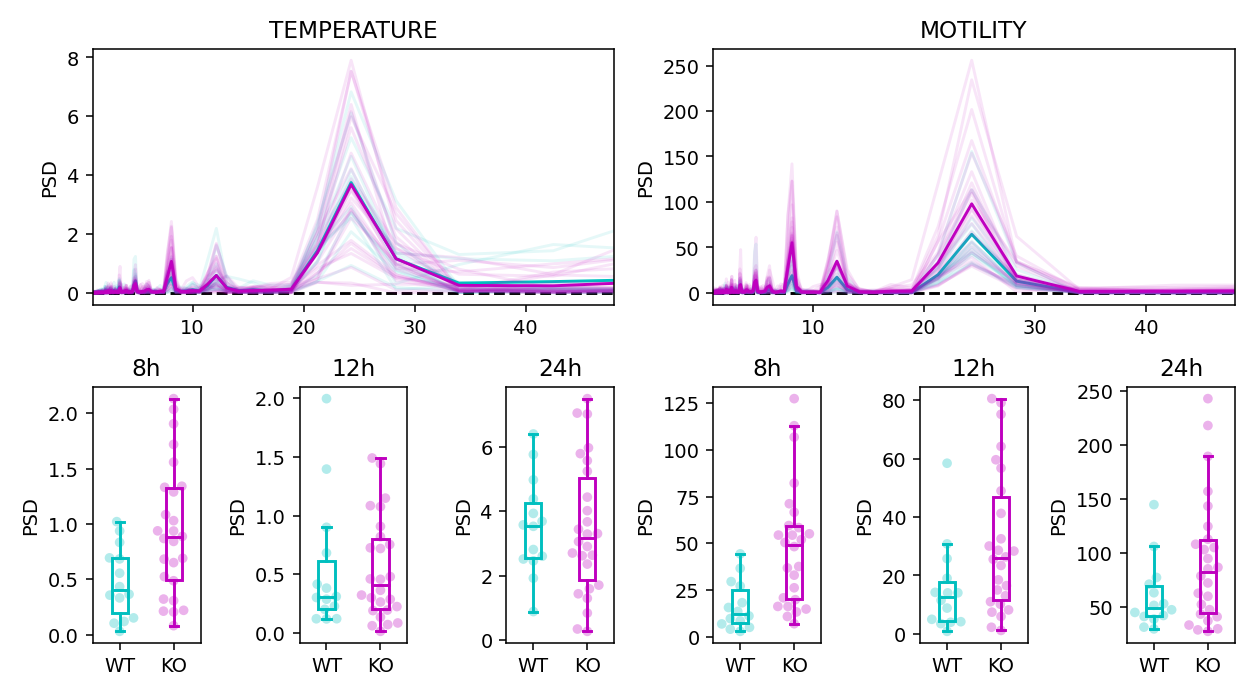

C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)
C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is 

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,0.118678,34.557734,two-sided,0.906218,"[-1.09, 1.23]",0.035705,0.322,0.051264,t24
T-test,-0.049805,21.884069,two-sided,0.960729,"[-0.36, 0.34]",0.017745,0.321,0.050312,t12
T-test,-3.193540,37.964431,two-sided,0.002824,"[-0.75, -0.17]",0.895666,13.326,0.749559,t8
T-test,-2.204863,37.987281,two-sided,0.033592,"[-60.57, -2.58]",0.616638,2.027,0.441704,m24
T-test,-2.518866,37.122809,two-sided,0.016210,"[-28.6, -3.1]",0.727321,3.472,0.570830,m12
T-test,-4.351145,35.930318,two-sided,0.000107,"[-46.15, -16.81]",1.150860,214.855,0.922595,m8


In [11]:
wt_temp_periodogram_data = temp_periodogram_data[temp_periodogram_data['geno']=='WT'].iloc[:,2:].T
ko_temp_periodogram_data = temp_periodogram_data[temp_periodogram_data['geno']=='KO'].iloc[:,2:].T

wt_mot_periodogram_data = mot_periodogram_data[mot_periodogram_data['geno']=='WT'].iloc[:,2:].T
ko_mot_periodogram_data = mot_periodogram_data[mot_periodogram_data['geno']=='KO'].iloc[:,2:].T

#fig,ax=plt.subplots()
fig, ax = plt.subplot_mosaic(
    [["temperature_spectrum", "temperature_spectrum", "temperature_spectrum","motion_spectrum", "motion_spectrum", "motion_spectrum"],
     ["t8", "t12", "t24", "m8", "m12", "m24"]], figsize=(9,5)
)

ax["temperature_spectrum"].axhline(0,color='k', linestyle='--')
ax["temperature_spectrum"].plot(wt_temp_periodogram_data.index, wt_temp_periodogram_data,'c',alpha=0.1)
ax["temperature_spectrum"].plot(wt_temp_periodogram_data.index, wt_temp_periodogram_data.mean(axis=1),'c',alpha=1)

ax["temperature_spectrum"].plot(ko_temp_periodogram_data.index, ko_temp_periodogram_data,'m',alpha=0.1)
ax["temperature_spectrum"].plot(ko_temp_periodogram_data.index, ko_temp_periodogram_data.mean(axis=1),'m',alpha=1)

ax["temperature_spectrum"].set_xlim([1,48])
ax['temperature_spectrum'].set_ylabel('PSD')
ax['temperature_spectrum'].set_title('TEMPERATURE')

ax["motion_spectrum"].axhline(0,color='k', linestyle='--')
ax["motion_spectrum"].plot(wt_mot_periodogram_data.index, wt_mot_periodogram_data,'c',alpha=0.1)
ax["motion_spectrum"].plot(wt_mot_periodogram_data.index, wt_mot_periodogram_data.mean(axis=1),'c',alpha=1)

ax["motion_spectrum"].plot(ko_mot_periodogram_data.index, ko_mot_periodogram_data,'m',alpha=0.1)
ax["motion_spectrum"].plot(ko_mot_periodogram_data.index, ko_mot_periodogram_data.mean(axis=1),'m',alpha=1)

ax["motion_spectrum"].set_xlim([1,48])
ax['motion_spectrum'].set_ylabel('PSD')
ax['motion_spectrum'].set_title('MOTILITY')

swarmbox(data=temp_periodogram_amps,x='geno',y='24',ax=ax['t24'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['24']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['24']
temp_periodogram_amps_stats_24 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_24['what'] = 't24'
ax['t24'].set_ylabel('PSD')
ax['t24'].set_xlabel('')
ax['t24'].set_title('24h')

swarmbox(data=mot_periodogram_amps,x='geno',y='24',ax=ax['m24'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['24']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['24']
mot_periodogram_amps_stats_24 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_24['what'] = 'm24'
ax['m24'].set_ylabel('PSD')
ax['m24'].set_xlabel('')
ax['m24'].set_title('24h')

swarmbox(data=temp_periodogram_amps,x='geno',y='12',ax=ax['t12'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['12']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['12']
temp_periodogram_amps_stats_12 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_12['what'] = 't12'
ax['t12'].set_ylabel('PSD')
ax['t12'].set_xlabel('')
ax['t12'].set_title('12h')

swarmbox(data=mot_periodogram_amps,x='geno',y='12',ax=ax['m12'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['12']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['12']
mot_periodogram_amps_stats_12 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_12['what'] = 'm12'
ax['m12'].set_ylabel('PSD')
ax['m12'].set_xlabel('')
ax['m12'].set_title('12h')

swarmbox(data=temp_periodogram_amps,x='geno',y='8',ax=ax['t8'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='WT']['8']
ko_temp_periodogram_amps = temp_periodogram_amps[temp_periodogram_amps['geno']=='KO']['8']
temp_periodogram_amps_stats_8 = pg.ttest(wt_temp_periodogram_amps,ko_temp_periodogram_amps)
temp_periodogram_amps_stats_8['what'] = 't8'
ax['t8'].set_ylabel('PSD')
ax['t8'].set_xlabel('')
ax['t8'].set_title('8h')

swarmbox(data=mot_periodogram_amps,x='geno',y='8',ax=ax['m8'],palette={'WT':'c','KO':'m'},order=['WT','KO'])
wt_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='WT']['8']
ko_mot_periodogram_amps = mot_periodogram_amps[mot_periodogram_amps['geno']=='KO']['8']
mot_periodogram_amps_stats_8 = pg.ttest(wt_mot_periodogram_amps,ko_mot_periodogram_amps)
mot_periodogram_amps_stats_8['what'] = 'm8'
ax['m8'].set_ylabel('PSD')
ax['m8'].set_xlabel('')
ax['m8'].set_title('8h')

plt.tight_layout()
pd.concat([temp_periodogram_amps_stats_24, temp_periodogram_amps_stats_12, temp_periodogram_amps_stats_8,
          mot_periodogram_amps_stats_24,mot_periodogram_amps_stats_12,mot_periodogram_amps_stats_8])


## Cosinor Analysis

<IPython.core.display.Javascript object>


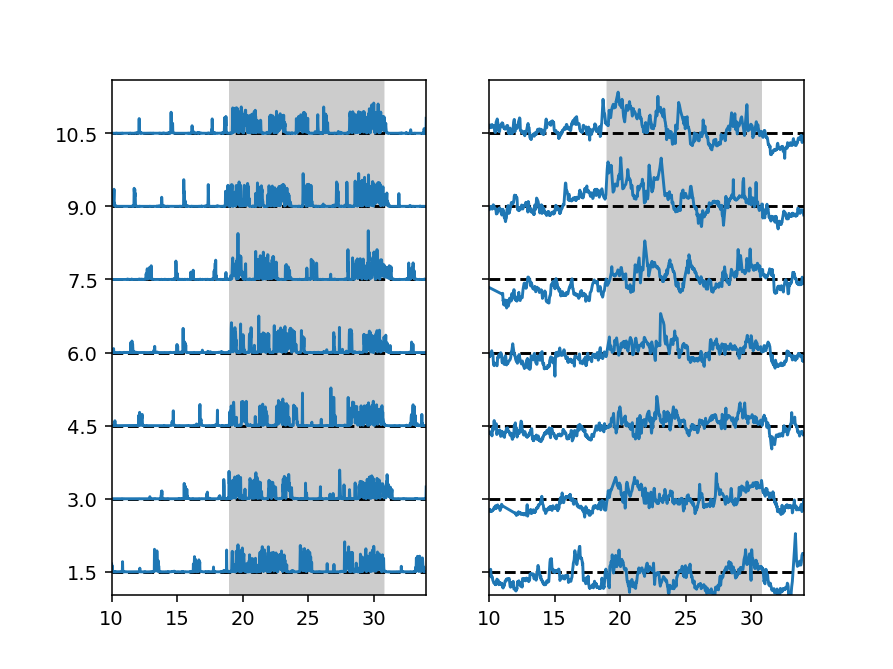

In [12]:
topo=4
temperature_each_day = sub.get_days_df(topo,'temp_rt_corrected')
motion_each_day = sub.get_days_df(topo,'distance')
isDay_each_day = sub.get_days_df(topo,'isDay').mean(axis=1)

temperature_each_day.index = 10+(temperature_each_day.index/60)
motion_each_day.index = 10+(motion_each_day.index/60)
isDay_each_day.index = 10+(isDay_each_day.index/60)

fig,ax = plt.subplots(1,2,sharex=True,sharey=True)
actogram(motion_each_day,ax=ax[0],baseline=True,isDay=isDay_each_day)
actogram(temperature_each_day,baseline=True,isDay=isDay_each_day,ax=ax[1])
    

<IPython.core.display.Javascript object>


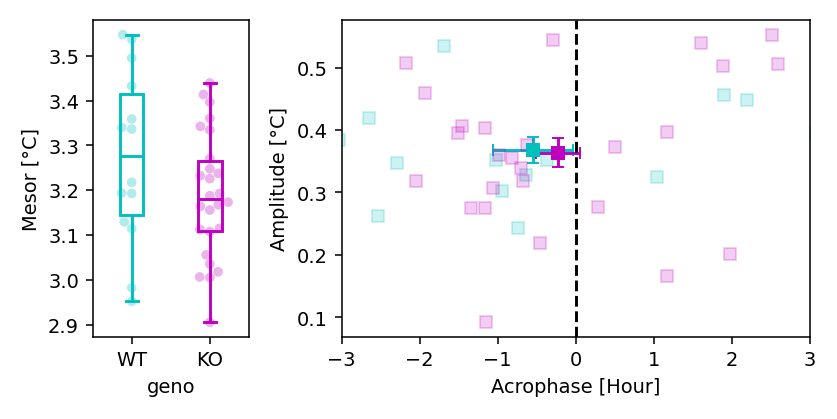

C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,1.454987,20.471406,two-sided,0.160836,"[-0.04, 0.21]",0.531803,0.726,0.346188,mesor
T-test,0.117766,36.322809,two-sided,0.906902,"[-0.06, 0.07]",0.034523,0.322,0.051182,amplitude
T-test,-0.548641,21.000463,two-sided,0.589037,"[-1.55, 0.9]",0.198555,0.36,0.089891,acrophase
T-test,0.241801,33.348490,two-sided,0.810415,"[-0.05, 0.07]",0.073887,0.328,0.055427,r2


In [13]:
from scipy.stats import circmean,circstd

group_cosinor = list()
for s,data_min in sub.iter_data():
    temperature = data_min['temp_rt_diff']
    temperature.index = 10+(temperature.index/60)
    cosinor = Cosinor(temperature, temperature.index, fixed24=True,  =True)
    cosinor.components['id']=s['id']
    cosinor.components['geno']=s['geno']
    group_cosinor.append( cosinor.components ) 
group_cosinor = pd.concat(group_cosinor)


fig,ax = plt.subplots(1,2,width_ratios=[1,3],figsize=(6,3))

swarmbox(data=group_cosinor,x='geno',y='mesor',ax=ax[0],palette={'WT':'c','KO':'m'},order=['WT','KO'])
ax[0].set_ylabel('Mesor [°C]')
#swarmbox(data=group_cosinor,x='geno',y='amplitude',ax=ax[1],palette={'WT':'c','KO':'m'},order=['WT','KO'])

def unwrap_hours(hour):
    if hour>12:
        if hour==24:
            return 0
        return hour-24
    else:
        return hour

wt_cosinor = group_cosinor[group_cosinor['geno']=='WT']
ko_cosinor = group_cosinor[group_cosinor['geno']=='KO']

wt_acrophase = wt_cosinor['acrophase'].apply(unwrap_hours)
ko_acrophase = ko_cosinor['acrophase'].apply(unwrap_hours)
wt_amplitude = wt_cosinor['amplitude'].apply(unwrap_hours)
ko_amplitude = ko_cosinor['amplitude'].apply(unwrap_hours)

ax[1].plot( wt_acrophase, wt_amplitude,'sc',alpha=.2)
ax[1].plot( wt_acrophase.mean(), wt_amplitude.mean(),'sc')
ax[1].errorbar(wt_acrophase.mean(), wt_amplitude.mean(),xerr=wt_acrophase.sem(), yerr=wt_amplitude.sem(), fmt ='sc',capsize=3)
ax[1].plot( ko_acrophase,ko_amplitude,'sm',alpha=.2)
ax[1].plot(ko_acrophase.mean(), ko_amplitude.mean(),'sm')
ax[1].errorbar(ko_acrophase.mean(), ko_amplitude.mean(),xerr=ko_acrophase.sem(), yerr=ko_amplitude.sem(), fmt ='sm',capsize=3)
ax[1].set_xlim(-3,3)
ax[1].axvline(0,color='k',linestyle='--')
ax[1].set_ylabel('Amplitude [°C]')
ax[1].set_xlabel('Acrophase [Hour]')

plt.tight_layout()

cos_stat_mesor = pg.ttest(wt_cosinor['mesor'],ko_cosinor['mesor'])
cos_stat_mesor['what']  = 'mesor'
cos_stat_amp = pg.ttest(wt_cosinor['amplitude'],ko_cosinor['amplitude'])
cos_stat_amp['what']  = 'amplitude'
cos_stat_acro = pg.ttest(wt_acrophase,ko_acrophase)
cos_stat_acro['what']  = 'acrophase'
cos_stat_r2 = pg.ttest(wt_cosinor['r2'],ko_cosinor['r2'])
cos_stat_r2['what']  = 'r2'

pd.concat([cos_stat_mesor,cos_stat_amp,cos_stat_acro,cos_stat_r2])

<IPython.core.display.Javascript object>


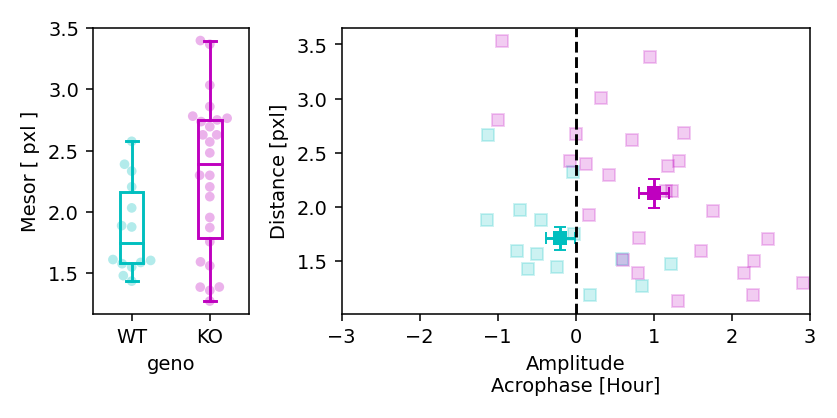

C:\Users\pupil\AppData\Local\Temp\ipykernel_4760\2594100801.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(data=data,x=x,y=y,palette=palette,ax=ax,alpha=.3,order=order)


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power,what
T-test,-2.707450,37.351240,two-sided,0.010167,"[-0.75, -0.11]",0.777633,4.933,0.627905,mesor
T-test,-2.434801,37.271115,two-sided,0.019804,"[-0.76, -0.07]",0.700684,2.988,0.539918,amplitude
T-test,-4.408915,34.537265,two-sided,0.000096,"[-1.75, -0.64]",1.326813,249.756,0.973778,acrophase
T-test,-0.397933,28.803619,two-sided,0.693613,"[-0.03, 0.02]",0.128496,0.341,0.066516,r2


In [14]:
from scipy.stats import circmean,circstd

group_cosinor = list()
for s,data_min in sub.iter_data():
    distance = data_min['distance']
    distance.index = 10+(distance.index/60)
    cosinor = Cosinor(distance, distance.index, fixed24=True, acroWrap=True)
    cosinor.components['id']=s['id']
    cosinor.components['geno']=s['geno']
    group_cosinor.append( cosinor.components ) 
group_cosinor = pd.concat(group_cosinor)


fig,ax = plt.subplots(1,2,width_ratios=[1,3],figsize=(6,3))

swarmbox(data=group_cosinor,x='geno',y='mesor',ax=ax[0],palette={'WT':'c','KO':'m'},order=['WT','KO'])
#swarmbox(data=group_cosinor,x='geno',y='amplitude',ax=ax[1],palette={'WT':'c','KO':'m'},order=['WT','KO'])
ax[0].set_ylabel('Mesor [ pxl ]')

def unwrap_hours(hour):
    if hour>12:
        if hour==24:
            return 0
        return hour-24
    else:
        return hour

wt_cosinor = group_cosinor[group_cosinor['geno']=='WT']
ko_cosinor = group_cosinor[group_cosinor['geno']=='KO']

wt_acrophase = wt_cosinor['acrophase'].apply(unwrap_hours)
ko_acrophase = ko_cosinor['acrophase'].apply(unwrap_hours)
wt_amplitude = wt_cosinor['amplitude'].apply(unwrap_hours)
ko_amplitude = ko_cosinor['amplitude'].apply(unwrap_hours)

ax[1].plot( wt_acrophase, wt_amplitude,'sc',alpha=.2)
ax[1].plot( wt_acrophase.mean(), wt_amplitude.mean(),'sc')
ax[1].errorbar(wt_acrophase.mean(), wt_amplitude.mean(),xerr=wt_acrophase.sem(), yerr=wt_amplitude.sem(), fmt ='sc',capsize=3)
ax[1].plot( ko_acrophase,ko_amplitude,'sm',alpha=.2)
ax[1].plot(ko_acrophase.mean(), ko_amplitude.mean(),'sm')
ax[1].errorbar(ko_acrophase.mean(), ko_amplitude.mean(),xerr=ko_acrophase.sem(), yerr=ko_amplitude.sem(), fmt ='sm',capsize=3)
ax[1].set_xlim(-3,3)
ax[1].axvline(0,color='k',linestyle='--')
ax[1].set_ylabel('Distance [pxl]')
ax[1].set_xlabel('Amplitude\nAcrophase [Hour]')

plt.tight_layout()

cos_stat_mesor = pg.ttest(wt_cosinor['mesor'],ko_cosinor['mesor'])
cos_stat_mesor['what']  = 'mesor'
cos_stat_amp = pg.ttest(wt_cosinor['amplitude'],ko_cosinor['amplitude'])
cos_stat_amp['what']  = 'amplitude'
cos_stat_acro = pg.ttest(wt_acrophase,ko_acrophase)
cos_stat_acro['what']  = 'acrophase'
cos_stat_r2 = pg.ttest(wt_cosinor['r2'],ko_cosinor['r2'])
cos_stat_r2['what']  = 'r2'

pd.concat([cos_stat_mesor,cos_stat_amp, cos_stat_acro, cos_stat_r2])

# Single Day

## Amplitude Stability  - Periodogram single day

In [15]:
wt_pds_24 = list()
ko_pds_24 = list()
for i,s in sub.subjects.iterrows():
    temp_days = sub.get_days_df(i,what='distance')
    d_per = list()
    for d in temp_days.columns:
        sd_period = Periodogram(temp_days[d])
        d_per.append( pd.Series(sd_period.power_spectrum,index=sd_period.period) )
    d_per = pd.concat(d_per,axis=1)
    if s['geno']=='WT':
        wt_pds_24.append(d_per.loc[24,:])
    else:
        ko_pds_24.append(d_per.loc[24,:])
wt_pds_24 = pd.concat(wt_pds_24,axis=1)
ko_pds_24 = pd.concat(ko_pds_24,axis=1)

<IPython.core.display.Javascript object>


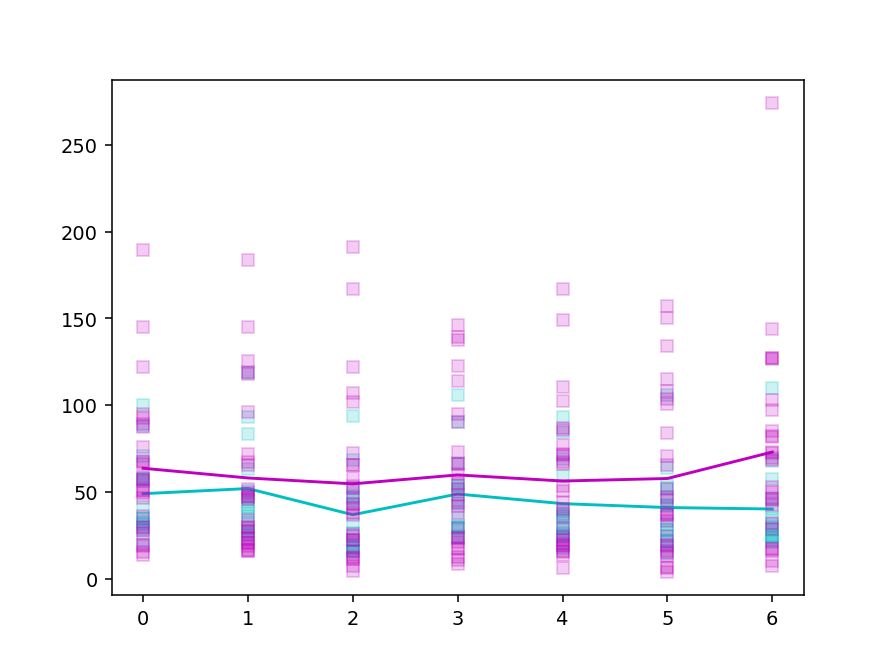

In [16]:
fig,ax = plt.subplots()
ax.plot(wt_pds_24,color='c',alpha=.2,marker='s',linestyle='')
ax.plot(wt_pds_24.mean(axis=1),color='c',alpha=1)
ax.plot(ko_pds_24,color='m',alpha=.2,marker='s',linestyle='')
ax.plot(ko_pds_24.mean(axis=1),color='m',alpha=1)

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller( wt_pds_24.mean(axis=1) )
print(result)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1]) #if p>0.05 is stationary. If significant is non-stationary

result = adfuller( ko_pds_24.mean(axis=1) )
print(result)
print('ADF Statistic: %f' % result[0]) 
print('p-value: %f' % result[1])


(-5.831409814414009, 3.96713201655067e-07, 1, 5, {'1%': -6.045114, '5%': -3.9292800000000003, '10%': -2.98681}, 24.63719953556044)
ADF Statistic: -5.831410
p-value: 0.000000
(-2.545519635103767, 0.1047879601279772, 0, 6, {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}, 37.79566216650204)
ADF Statistic: -2.545520
p-value: 0.104788


In [18]:
from statsmodels.tsa.stattools import kpss

result = kpss(wt_pds_24.mean(axis=1), regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# Since the p-value is high than the significance level (0.05)
# we cannot reject the null hypothesis and
# it means that it is stationary

# NON-STATIONARY
result = kpss(ko_pds_24.mean(axis=1), regression='c')
print('KPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])



KPSS Statistic: 0.500000
p-value: 0.041667
KPSS Statistic: 0.141977
p-value: 0.100000


C:\ProgramData\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [6]:
temp_wt = temperature.xs('WT',level=0,axis=1)
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt

In [5]:
x

NameError: name 'x' is not defined

<IPython.core.display.Javascript object>


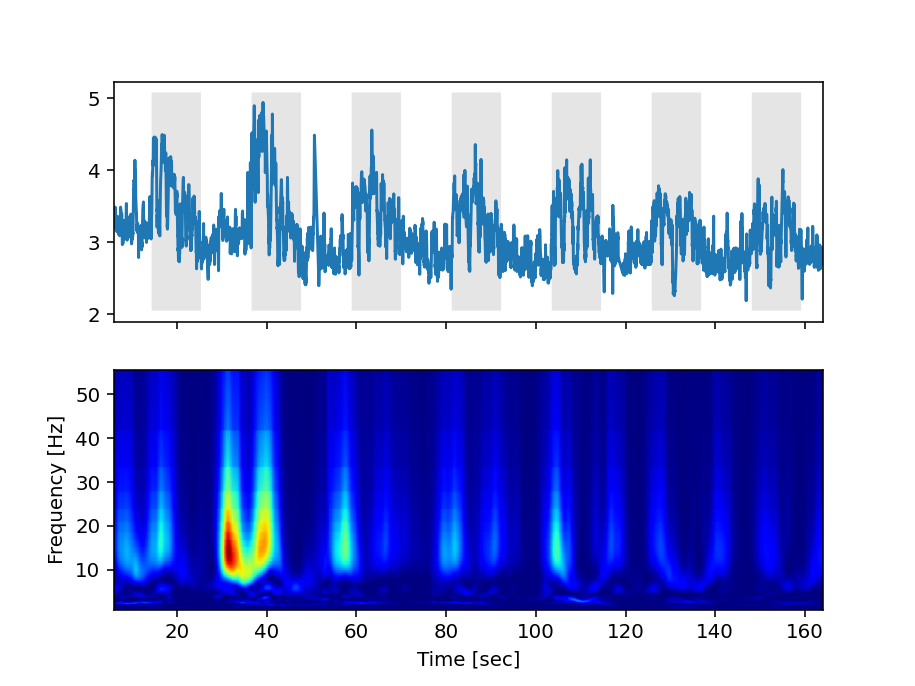

Text(0.5, 0, 'Time [sec]')

In [14]:
%notebook inline
x = temp_wt.iloc[:,0]
fs = 60
f, t, Sxx = signal.spectrogram(x, fs,nperseg=int(720),noverlap=700,nfft=10000)
time_x = np.linspace(t[0],t[-1],len(x))
x.index = time_x

fig,ax = plt.subplots(2,1,sharex=True)

ax[0].plot(x)
ylims = ax[0].get_ylim()
ax[0].fill_between(x.index, y1=ylims[0], y2=ylims[1], where=isDay<1,alpha=.2, color='gray',edgecolor='none')
foi = np.where((f<1)&(f>0.015))[0]
ax[1].pcolormesh(t, np.nan_to_num(1/f[foi],posinf=0), Sxx[foi,:], shading='gouraud',cmap='jet')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_xlabel('Time [sec]')
